# Face Recognation 
Project based on: [Build a Deep Facial Recognition App](https://www.youtube.com/watch?v=bK_k7eebGgc&list=PLgNJO2hghbmhHuhURAGbe6KWpiYZt0AMH)

# 1. Set up and get data

# 1.1 Install dependencies

!pip install tensorflow

In [24]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

## 1.2 Collect images using openCV

In [2]:
import os
import time
import uuid # for unique id
import cv2

In [15]:
IMAGES_PATH = os.path.join('data', 'images')
NUM_IMAGES_TO_COLLECT = 20

In [16]:
# Conection to video camera and get images
cap = cv2.VideoCapture(0) # if you are on winodws try 1 instead of 0
for imgnum in range(NUM_IMAGES_TO_COLLECT):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'): # turn off the camera
        break
cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate images with labelMe

In [19]:
#/Users/asialalala/.local/pipx/venvs/labelme/bin/labelme
!labelme

2024-05-04 18:37:50,507 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\biuro\.labelmerc


# 2. Review Dataset and Build Image Loading Function

## 2.1 Import packages

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

## 2.2 Limit GPU Memory Growth

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
# WARNING!!!! It should be trye, but it is false

In [24]:
# check if tensorflow is available
tf.config.list_physical_devices('GPU')
#tf.config.list_physical_devices('GPU')
tf.test.is_gpu_available()

False

In [23]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [24]:
# variable 'images' contains path to images files
images.as_numpy_iterator().next()

b'data\\images\\1e466128-07fb-11ef-849f-64d2c4ecd148.jpg'

In [12]:
# read images and load them as jpeg to img
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [25]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

## 2.4 View Raw Images with Matplotlib

In [80]:
image_genarator = images.batch(4).as_numpy_iterator()

In [81]:
plot_images = image_genarator.next() #geting new batch of data, can be ran multiple time

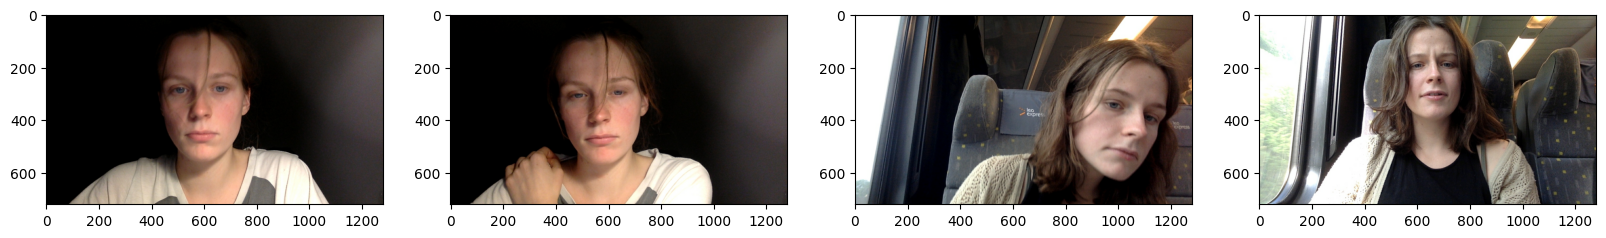

In [82]:
#show 4 images, if you want another butch just ran cell below and then this one
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()                      

# 3. Partition Unaugmented Data

## 3.1 Manually Split Sata into Train Test and Val

In [ ]:
#if we add new data we need to also divide it and add to folders

In [51]:
176*0.7 #123 to train

123.19999999999999

In [52]:
176*.15 # 26 and 27 to test and val

26.4

## 3.2 Move the Matching Labels

In [ ]:
#moving matching labels to the photos in new folders
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath) 
#i'm not sure if it do it for all files but it did for some

# 4. Apply Image Augmentation on Images and Labels using Albumentations

## 4.1 Setup Albumentations Transform Pipline

In [28]:
import albumentations as alb

In [29]:
#adjust photos and normalization (bbox)
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450),
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2),
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)
], bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))


## 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [30]:
img = cv2.imread(os.path.join('data','train','images','547b89de-07fc-11ef-b710-64d2c4ecd148.jpg')) #if dosen't return error -> works

In [31]:
with open(os.path.join('data','train','labels','547b89de-07fc-11ef-b710-64d2c4ecd148.json'), 'r') as f:
    label = json.load(f)

In [32]:
#label #to check if it works, also can check type or use label['shapes'] or label['shapes'][0]['points'] for coordinate

## 4.3 Extract Cooridnates and Rescale to Match Image Resolution

In [33]:
coords = [0,0,0,0]
coords[0]=label['shapes'][0]['points'][0][0]
coords[1]=label['shapes'][0]['points'][0][1]
coords[2]=label['shapes'][0]['points'][1][0]
coords[3]=label['shapes'][0]['points'][1][1]

In [34]:
coords #vector with coordinates

[336.2121212121213, 43.33333333333337, 758.939393939394, 570.6060606060606]

In [35]:
#this adjust to picture width and height and works better
img_width = img.shape[1] #x
img_height = img.shape[0] #y
coords = list(np.divide(coords, [img_width, img_height, img_width, img_height]))

In [36]:
coords

[0.2626657196969698,
 0.06018518518518524,
 0.5929214015151516,
 0.7925084175084175]

## 4.4 Apply Augmentation and View Results

In [37]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) 

In [41]:
augmented['bboxes']

[(0.0, 0.0022222222222222365, 0.6865319865319867, 0.9977777777777778)]

In [43]:
len(augmented['bboxes'])

0

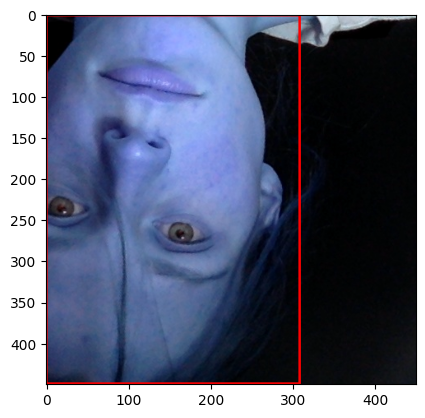

In [39]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              (255,0,0),2)

plt.imshow(augmented['image']) #can be blue its still correct

# 5. Bulid and Run Augmentation Pipeline

## 5.1 Run Augmentation Pipeline

In [75]:
for folder in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', folder, 'images')):
        img = cv2.imread(os.path.join('data', folder, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        filename = image.split('.')[0] + '.json'
        label_path = os.path.join('data', folder, 'labels', filename)
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            img_width = img.shape[1] # x
            img_height = img.shape[0] # y
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [img_width, img_height, img_width, img_height]))

        try:
            for x in range(60):  #create 60 new images for every image in Database
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                
                new_image_name = f'{image.split(".")[0]}_{x}.jpg'  
                cv2.imwrite(os.path.join('aug_data', folder, 'images', new_image_name), augmented['image'])

                annotation = {}
                annotation['image'] = image  

                if os.path.exists(label_path):
                    annotation['bboxes'] = augmented['bboxes'][0]
                    annotation['class'] = 1
                else:
                    annotation['bboxes'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', folder, 'labels', f'{image.split(".")[0]}_{x}.json'), 'w') as f: 
                    json.dump(annotation, f)
        except Exception as e:
            print(e)
                        

[696.8181818181818, 22.121212121212153, 1093.7878787878788, 556.969696969697]
list index out of range
[645.3030303030303, 0.9090909090909438, 1030.1515151515152, 540.3030303030303]
list index out of range
[607.4242424242425, 5.454545454545489, 924.0909090909092, 399.3939393939394]
list index out of range
[531.6666666666667, 26.6666666666667, 834.6969696969697, 393.3333333333333]
list index out of range
[534.6969696969697, 8.484848484848518, 818.030303030303, 391.8181818181818]
list index out of range
[490.7575757575758, 76.6666666666667, 854.3939393939395, 588.7878787878788]
list index out of range
[437.7272727272728, 3.939393939393973, 869.5454545454547, 613.030303030303]
[434.6969696969697, 6.969696969697004, 871.0606060606062, 606.969696969697]
[431.6666666666667, 8.484848484848518, 868.030303030303, 611.5151515151515]
[434.6969696969697, 13.030303030303063, 863.4848484848485, 608.4848484848485]
[448.3333333333333, 8.484848484848518, 860.4545454545455, 576.6666666666666]
[445.303030

## 5.2 Load Augmented Images to Tensorflow Dataset

In [76]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/225) #scaling and resize to work better at network while teaching

In [77]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/225)

In [78]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/225)

# 6. Prepare Labels

## 6.1 Build Label Loading Function

In [79]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']],label['bboxes']

## 6.2 Load Labels to Tensorflow Dataset

In [80]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [81]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [82]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 7. Combine Label and Image Samples

## 7.1 Check Partition Lengths

In [83]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2970, 2878, 400, 376, 430, 404)

## 7.2 Create Final Datasets (Images/Labels)

In [84]:
train = tf.data.Dataset.zip((train_images,train_labels)) #combining 
train = train.shuffle(10000) #bigger than len(train_images)
train = train.batch(8) 
train = train.prefetch(4) #eliminate bottlenecks

In [85]:
test = tf.data.Dataset.zip((test_images,test_labels))
test = test.shuffle(2000)
test = test.batch(8)
test = test.prefetch(4)

In [86]:
val = tf.data.Dataset.zip((val_images,val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [87]:
train.as_numpy_iterator().next()[0].shape #8 images, 120x120, 3 colors

(8, 120, 120, 3)

## 7.3 View Images and Annotation

In [88]:
data_sample=train.as_numpy_iterator()

In [89]:
res = data_sample.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0.     0.     0.398  0.9976]
[0.002222 0.       0.6084   0.9976  ]
[0.536    0.002222 0.9976   0.665   ]
[0. 0. 0. 0.]


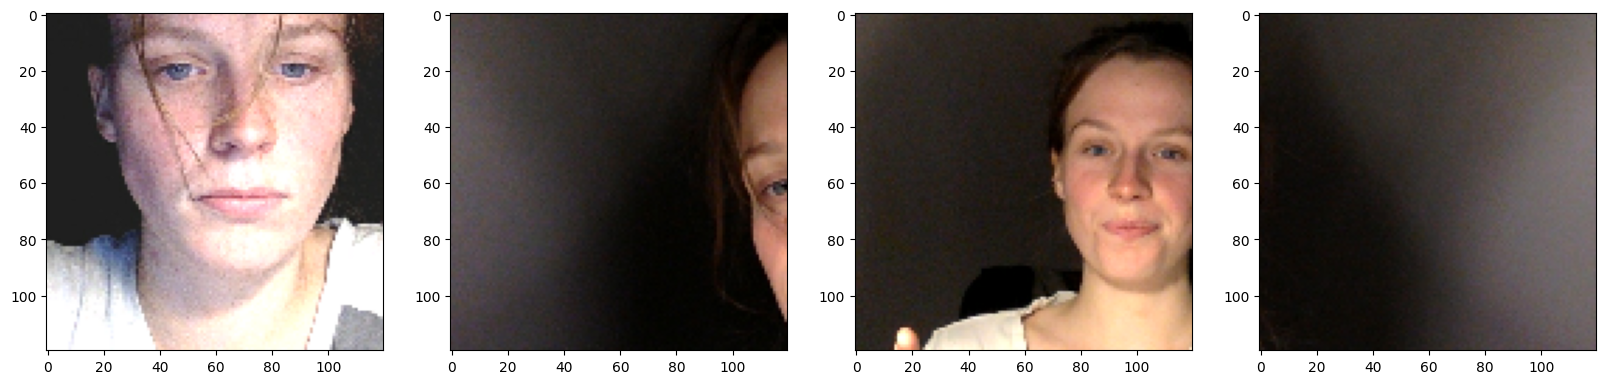

In [103]:
fif, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    print(sample_coords)
    
    cv2.rectangle(cv2.UMat(sample_image),
              tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
              (2,0,0),2)
    ax[idx].imshow(sample_image)